In [403]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
from splinter import Browser
from datetime import datetime
import json

from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF, IDF

executable_path = {'executable_path': '/usr/local/bin/chromedriver'}
browser = Browser('chrome', **executable_path, headless=False)

In [ ]:
file = "MasterData_Wilson.xlsx"
pd_file = pd.read_excel(file)
bakery_df = pd.DataFrame(pd_file)
bakery_df.head()

In [ ]:
bakery_df.columns

In [ ]:
bakery_df = bakery_df[['date', 'time', 'year', 'MonthN', 'Month', 'WeekN', 'Day', 'WeekD', 'H',
       'Min', '30min', 'Rtime', '30time', 'H.5', 'Operation', 'Line Item',
       'Department', 'Category', 'Supplier', 'Supplier Code', 'Cost', 'Price',
       'Quantity', 'Modifiers', 'Subtotal', 'Discounts', 'Net Total', 'Tax',
       'Total Due']]

In [ ]:
bakery_df.dtypes

In [ ]:
bakery_df['year'] = bakery_df['year'].fillna(0.0).astype(int)
bakery_df.loc[bakery_df['year'] == 0, :]

In [ ]:
bakery_df['year'].value_counts()

In [ ]:
bakery_df = bakery_df.drop(index=416580)
bakery_df.loc[bakery_df['year'] == 0, :]

In [ ]:
bakery_df['MonthN'] = bakery_df['MonthN'].fillna(0.0).astype(int)
bakery_df['WeekN'] = bakery_df['WeekN'].fillna(0.0).astype(int)
bakery_df['Day'] = bakery_df['Day'].fillna(0.0).astype(int)

In [ ]:
cln_bakery_df = bakery_df[['date','time', 'WeekN', 'WeekD', 'Rtime', 'Operation', 'Line Item', 'Department', \
                           'Category', 'Supplier', 'Supplier Code', 'Cost', 'Price','Quantity', \
                           'Modifiers', 'Subtotal', 'Discounts', 'Net Total', 'Tax', 'Total Due']]

In [ ]:
cln_bakery_df.head()

In [3]:
damen_reviews = []
belmont_reviews = []
logan_reviews = []

damen_bakeries = ["https://www.yelp.com/biz/la-boulangerie-chicago-4?sort_by=date_desc", \
                  "https://www.yelp.com/biz/la-boulangerie-chicago-4?start=20&sort_by=date_desc", \
                  "https://www.yelp.com/biz/la-boulangerie-chicago-4?start=40&sort_by=date_desc", \
                  "https://www.yelp.com/biz/la-boulangerie-chicago-4?start=60&sort_by=date_desc"]
belmont_bakeries = ['https://www.yelp.com/biz/la-boulangerie-chicago-2?sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=20&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=40&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=60&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=80&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=100&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=120&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=140&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=160&sort_by=date_desc']
logan_bakeries = ['https://www.yelp.com/biz/la-boulangerie-chicago-8?sort_by=date_desc', \
                 'https://www.yelp.com/biz/la-boulangerie-chicago-8?start=20&sort_by=date_desc']


In [4]:
def yelp_bakery_lookup(bakery_list, review_list):
    for link in bakery_list:
        bakery_response = requests.get(link)
        bakery_soup = bs(bakery_response.text, 'html.parser')
        bakery_results = bakery_soup.body.find_all('div', class_='review--with-sidebar')
        for review in bakery_results:
            user_info = []
            user_stats = []
            user_name = '' 
            user_loc = ''
            user_friends = ''
            user_reviews = ''
            user_photos = ''
            review_info = []
            review_stars = ''
            review_date = ''
            review_text = ''
            user_check_ins = ''
            elite = ''
            elite_status = ''
            photo = []
            photo_links = []
            review_data = []
            previous_review = []
            previous_rating = []

            user_information = {}

            try:
                user_info = review.find('ul', class_='user-passport-info')
                user_stats = review.find('ul', class_='user-passport-stats')
                review_info = review.find('div', class_='review-content')
                review_footer = review.find('div', class_='review-footer')

                try:
                    user_name = user_info.find('li', class_='user-name').find('a').text.strip()
                    user_profile_link = user_info.find('a', class_='user-display-name').attrs['href']
                    user_profile_link = "https://www.yelp.com" + user_profile_link
                    user_loc = user_info.find('li', class_='user-location').find('b').text.strip()
                    review_stars = review_info.find('div', class_='i-stars').attrs['title']
                    review_stars = int(float(review_stars.split()[0]))
                    review_date = review_info.find('span', class_='rating-qualifier').text.strip()
                    review_text = review_info.find('p').text
                except AttributeError as error:
                    print(error)

                try:
                    user_friends = user_stats.find('li', class_='friend-count').find('b').text.strip()
                except AttributeError as error:
                    if user_stats:
                        user_friends = '0'

                try:
                    user_reviews = user_stats.find('li', class_='review-count').find('b').text.strip()
                except AttributeError as error:
                    if user_stats:
                        user_reviews = '0'

                try:
                    user_photos = user_stats.find('li', class_='photo-count').find('b').text.strip()
                except AttributeError as error:
                    if user_stats:
                        user_photos = '0'

                try:
                    elite = user_stats.find('li', class_='is-elite')
                    if elite:
                        elite_status = 'elite'
                    else:
                        elite_status = 'not elite'
                except AttributeError as error:
                    print(error)

                try:
                    user_check_ins = review_info.find('li', class_='review-tags_item').find('span').text.strip()
                    user_check_ins = user_check_ins.split()[0]
                except AttributeError as error:
                    if review_info:
                        user_check_ins = '0'

                try:
                    photos = review_info.find('ul', class_='photo-box-grid')
                    if photos:
                        try:
                            picture = photos.find_all('div', class_='photo-box')
                            for pic in picture:
                                pic_link = ''
                                pic_link = pic.find('img').attrs['data-async-src']
                                photo_links.append(pic_link)
                        except Exception as error:
                            print(error)

                except AttributeError as error:
                    if review_info:
                        photo_links = []

                try:
                    review_options = review_footer.find_all('li', class_='vote-item')
                    review_data = {
                        'review_type' : [],
                        'review_count' : []
                    }
                    for option in review_options:
                        review_type = ''
                        review_count = ''
                        review_type = option.find('a').find('span', class_='vote-type').text.strip()
                        review_count = option.find('a').find('span', class_='count').text.strip()
                        if review_count == '':
                            review_count = '0'
                        review_data['review_type'].append(review_type)
                        review_data['review_count'].append(review_count)
                except AttributeError as error:
                    print(error)

                try:
                    previous_review = review.find('div', class_='previous-review')
                    if previous_review:
                        prev_star = previous_review.find('div', class_='i-stars').attrs['title']
                        prev_star = int(float(prev_star.split()[0]))
                        prev_date = previous_review.find('span', class_='rating-qualifier').text.strip()
                        prev_text = previous_review.find('span', class_=['hidden']).text.strip()
                        prev_review_options = previous_review.find_all('li', class_='vote-item')
                        prev_review_data = {
                            'review_type' : [],
                            'review_count' : []
                        }
                        for option in prev_review_options:
                            review_type = ''
                            review_count = ''
                            review_type = option.find('a').find('span', class_='vote-type').text.strip()
                            review_count = option.find('a').find('span', class_='count').text.strip()
                            if review_count == '':
                                review_count = '0'
                            prev_review_data['review_type'].append(review_type)
                            prev_review_data['review_count'].append(review_count)
                        previous_rating = {
                            'stars' : prev_star,
                            'review_date' : prev_date,
                            'review_text' : prev_text,
                            'review_feedback' : prev_review_data
                        }
                except AttributeError as error:
                    previous_review = []
                    print(error)

                if (user_name and user_loc and user_friends and user_reviews and user_photos and review_stars \
                    and review_date and user_check_ins and user_profile_link and review_text):
                    try:
                        user_check_ins = int(user_check_ins)
                    except ValueError as error:
                        user_check_ins = 0
                    counts = review_data['review_count']
                    user_information = {
                        'user_name' : user_name,
                        'user_location' : user_loc,
                        'user_link' : user_profile_link,
                        'user_friends' : int(user_friends),
                        'user_reviews' : int(user_reviews),
                        'user_photos' : int(user_photos),
                        'stars' : review_stars,
                        'review_date' : review_date,
                        'review_text' : review_text,
                        'review_photos' : photo_links,
                        'useful_rating_count' : counts[0],
                        'funny_rating_count' : counts[1],
                        'cool_rating_count' : counts[2],
                        'check_ins' : user_check_ins,
                        'elite_status' : elite_status,
                        'previous_review' : previous_rating
                    }

                    review_list.append(user_information)
            except AttributeError as error:
                print(error)

#     print(json.dumps(review_list, indent=4, sort_keys=True))

In [5]:
yelp_bakery_lookup(damen_bakeries, damen_reviews)
yelp_bakery_lookup(belmont_bakeries, belmont_reviews)
yelp_bakery_lookup(logan_bakeries, logan_reviews)

'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneT

In [6]:
print(len(damen_reviews))
print(len(belmont_reviews))
print(len(logan_reviews))

71
176
37


In [7]:
damen_review_df = pd.DataFrame(damen_reviews).set_index('user_name')
damen_review_df.head()

,check_ins,cool_rating_count,elite_status,funny_rating_count,previous_review,review_date,review_photos,review_text,stars,useful_rating_count,user_friends,user_link,user_location,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,
Sonja M.,0,0,not elite,0,"{'stars': 5, 'review_date': '6/2/2018 ...",1/3/2019\n \n\n\n\n\n\nUpdated review,[],I just stopped by this cafe for the first time...,5,0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22
Courtney J.,0,1,elite,1,[],12/31/2018,[],I adore this neighborhood bakery. It is a few ...,5,0,263,https://www.yelp.com/user_details?userid=aqkJ_...,"Chicago, IL",10,61
Sabrina G.,1,0,elite,0,[],12/23/2018,[https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8...,I've been dreaming of quiche and croissants as...,5,0,195,https://www.yelp.com/user_details?userid=LlGh8...,"Chicago, IL",82,52
Alfie B.,0,1,elite,0,[],10/10/2018,[https://s3-media4.fl.yelpcdn.com/bphoto/oLYVK...,We came to La Boulangerie after recommendation...,5,0,17,https://www.yelp.com/user_details?userid=mymQs...,"Columbia, SC",326,107
Anna L.,0,1,elite,1,[],10/9/2018,[],This is a great breakfast spot. Even better if...,5,1,28,https://www.yelp.com/user_details?userid=1aah9...,"Columbia, SC",145,176


In [8]:
damen_review_df.columns

Index(['check_ins', 'cool_rating_count', 'elite_status', 'funny_rating_count',
       'previous_review', 'review_date', 'review_photos', 'review_text',
       'stars', 'useful_rating_count', 'user_friends', 'user_link',
       'user_location', 'user_photos', 'user_reviews'],
      dtype='object')

In [9]:
damen_review_df = damen_review_df[['review_date', 'stars', 'user_location', 'review_text', 'check_ins', 'cool_rating_count', 'useful_rating_count', \
                       'funny_rating_count', 'review_photos', 'previous_review', 'elite_status', 'user_link', 'user_friends', \
                       'user_photos', 'user_reviews']]
damen_review_df.head()

,review_date,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,previous_review,elite_status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,
Sonja M.,1/3/2019\n \n\n\n\n\n\nUpdated review,5,"Chicago, IL",I just stopped by this cafe for the first time...,0,0,0,0,[],"{'stars': 5, 'review_date': '6/2/2018 ...",not elite,https://www.yelp.com/user_details?userid=VtVHE...,63,2,22
Courtney J.,12/31/2018,5,"Chicago, IL",I adore this neighborhood bakery. It is a few ...,0,1,0,1,[],[],elite,https://www.yelp.com/user_details?userid=aqkJ_...,263,10,61
Sabrina G.,12/23/2018,5,"Chicago, IL",I've been dreaming of quiche and croissants as...,1,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8...,[],elite,https://www.yelp.com/user_details?userid=LlGh8...,195,82,52
Alfie B.,10/10/2018,5,"Columbia, SC",We came to La Boulangerie after recommendation...,0,1,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/oLYVK...,[],elite,https://www.yelp.com/user_details?userid=mymQs...,17,326,107
Anna L.,10/9/2018,5,"Columbia, SC",This is a great breakfast spot. Even better if...,0,1,1,1,[],[],elite,https://www.yelp.com/user_details?userid=1aah9...,28,145,176


In [10]:
belmont_review_df = pd.DataFrame(belmont_reviews).set_index('user_name')
belmont_review_df = belmont_review_df[['review_date', 'stars', 'user_location', 'review_text', 'check_ins', 'cool_rating_count', 'useful_rating_count', \
                       'funny_rating_count', 'review_photos', 'previous_review', 'elite_status', 'user_link', 'user_friends', \
                       'user_photos', 'user_reviews']]
belmont_review_df.head()


,review_date,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,previous_review,elite_status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,
Elise M.,12/27/2018\n \n\n\n\n\n\nUpdated re...,4,"Chicago, IL",2018 Updated Review:This place closed for seve...,0,0,0,0,[],"{'stars': 5, 'review_date': '10/7/2017 ...",not elite,https://www.yelp.com/user_details?userid=TY4Ct...,0,13,36
John D.,7/1/2018\n \n\n\n\n\n\nUpdated review,5,"Chicago, IL",Such a beautiful pleasant atmosphere. Highly r...,0,0,0,0,[],[],not elite,https://www.yelp.com/user_details?userid=5AL4m...,1,0,134
Hunny B.,5/3/2018,4,"Chicago, IL",I am reluctant to write this review because I ...,0,0,0,0,[],[],not elite,https://www.yelp.com/user_details?userid=NtC8R...,5,14,31
Tee L.,3/21/2018,4,"Chicago, IL",Cute lil set up with courteous staff. First ti...,0,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/-b6RZ...,[],not elite,https://www.yelp.com/user_details?userid=grtg2...,7,423,139
Rose O.,3/9/2018,4,"Chicago, IL",Their caprese sandwich is just OK but i really...,1,0,0,0,[],[],not elite,https://www.yelp.com/user_details?userid=uAacY...,408,1,98


In [11]:
logan_review_df = pd.DataFrame(logan_reviews).set_index('user_name')
logan_review_df = logan_review_df[['review_date', 'stars', 'user_location', 'review_text', 'check_ins', 'cool_rating_count', 'useful_rating_count', \
                       'funny_rating_count', 'review_photos', 'previous_review', 'elite_status', 'user_link', 'user_friends', \
                       'user_photos', 'user_reviews']]
logan_review_df.head()


,review_date,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,previous_review,elite_status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,
Erin H.,12/29/2018\n \n\n\n\n\n\nUpdated re...,5,"Chicago, IL",This place has the BEST croissant I've had in ...,1,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/efFTu...,"{'stars': 5, 'review_date': '10/8/2018 ...",not elite,https://www.yelp.com/user_details?userid=Y0Yt3...,120,15,64
Hope B.,11/13/2018,5,"Chicago, IL",I found this French cafe accidentally when I o...,0,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/F-Kg9...,[],not elite,https://www.yelp.com/user_details?userid=pLPd1...,38,1,3
Katherine A.,11/13/2018,5,"Ballwin, MO",Yes. This is what you want. Comfortable feel...,0,0,0,0,[https://s3-media1.fl.yelpcdn.com/bphoto/2vf2F...,[],elite,https://www.yelp.com/user_details?userid=1pT3x...,10,145,81
Anna G.,11/12/2018,5,"Evanston, IL",Cozy spot for a quick bite or to settle in and...,0,0,1,0,[],[],elite,https://www.yelp.com/user_details?userid=4tkkD...,13,89,65
Kelly J.,10/19/2018,5,"Chicago, IL",New York has nothing on French bakeries compar...,0,0,0,0,[],[],not elite,https://www.yelp.com/user_details?userid=OQVAE...,0,0,12


In [12]:
for index, row in damen_review_df.iterrows():
    if len(row['review_date']) > 15:
        print("Update!")
        damen_review_df.loc[index, 'Updated'] = '1'
        prev = row.previous_review
        damen_review_df.loc[index, 'prev_text'] = prev['review_text']
        damen_review_df.loc[index, 'prev_stars'] = prev['stars']
        damen_review_df.loc[index, 'prev_date'] = prev['review_date']
        counts = prev['review_feedback']['review_count']
        damen_review_df.loc[index, 'prev_useful_rating_count'] = counts[0]
        damen_review_df.loc[index, 'prev_funny_rating_count'] = counts[1]
        damen_review_df.loc[index, 'prev_cool_rating_count'] = counts[2]
    else:
        damen_review_df.loc[index, 'Updated'] = '0'
damen_review_df.head()

Update!
Update!


,review_date,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,previous_review,...,user_friends,user_photos,user_reviews,Updated,prev_text,prev_stars,prev_date,prev_useful_rating_count,prev_funny_rating_count,prev_cool_rating_count
user_name,,,,,,,,,,,,,,,,,,,,,
Sonja M.,1/3/2019\n \n\n\n\n\n\nUpdated review,5,"Chicago, IL",I just stopped by this cafe for the first time...,0,0,0,0,[],"{'stars': 5, 'review_date': '6/2/2018 ...",...,63,2,22,1,I just stopped by this cafe for the first time...,5.0,6/2/2018\n \nPrevious review,0,0,0
Courtney J.,12/31/2018,5,"Chicago, IL",I adore this neighborhood bakery. It is a few ...,0,1,0,1,[],[],...,263,10,61,0,NaN,NaN,NaN,NaN,NaN,NaN
Sabrina G.,12/23/2018,5,"Chicago, IL",I've been dreaming of quiche and croissants as...,1,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8...,[],...,195,82,52,0,NaN,NaN,NaN,NaN,NaN,NaN
Alfie B.,10/10/2018,5,"Columbia, SC",We came to La Boulangerie after recommendation...,0,1,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/oLYVK...,[],...,17,326,107,0,NaN,NaN,NaN,NaN,NaN,NaN
Anna L.,10/9/2018,5,"Columbia, SC",This is a great breakfast spot. Even better if...,0,1,1,1,[],[],...,28,145,176,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
for index, row in belmont_review_df.iterrows():
    if len(row['review_date']) > 15:
        print("Update!")
        belmont_review_df.loc[index, 'Updated'] = '1'
        prev = row.previous_review
        try:
            belmont_review_df.loc[index, 'prev_text'] = prev['review_text']
            belmont_review_df.loc[index, 'prev_stars'] = prev['stars']
            belmont_review_df.loc[index, 'prev_date'] = prev['review_date']
            counts = prev['review_feedback']['review_count']
            belmont_review_df.loc[index, 'prev_useful_rating_count'] = counts[0]
            belmont_review_df.loc[index, 'prev_funny_rating_count'] = counts[1]
            belmont_review_df.loc[index, 'prev_cool_rating_count'] = counts[2]
        except TypeError as error:
            print(error)
    else:
        belmont_review_df.loc[index, 'Updated'] = '0'
belmont_review_df.head()

Update!
Update!
list indices must be integers or slices, not str
Update!
Update!
Update!
Update!
Update!


,review_date,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,previous_review,...,user_friends,user_photos,user_reviews,Updated,prev_text,prev_stars,prev_date,prev_useful_rating_count,prev_funny_rating_count,prev_cool_rating_count
user_name,,,,,,,,,,,,,,,,,,,,,
Elise M.,12/27/2018\n \n\n\n\n\n\nUpdated re...,4,"Chicago, IL",2018 Updated Review:This place closed for seve...,0,0,0,0,[],"{'stars': 5, 'review_date': '10/7/2017 ...",...,0,13,36,1,They have a Gourmet Breakfast Sandwich that is...,5.0,10/7/2017\n \nPrevious review,1,0,0
John D.,7/1/2018\n \n\n\n\n\n\nUpdated review,5,"Chicago, IL",Such a beautiful pleasant atmosphere. Highly r...,0,0,0,0,[],[],...,1,0,134,1,NaN,NaN,NaN,NaN,NaN,NaN
Hunny B.,5/3/2018,4,"Chicago, IL",I am reluctant to write this review because I ...,0,0,0,0,[],[],...,5,14,31,0,NaN,NaN,NaN,NaN,NaN,NaN
Tee L.,3/21/2018,4,"Chicago, IL",Cute lil set up with courteous staff. First ti...,0,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/-b6RZ...,[],...,7,423,139,0,NaN,NaN,NaN,NaN,NaN,NaN
Rose O.,3/9/2018,4,"Chicago, IL",Their caprese sandwich is just OK but i really...,1,0,0,0,[],[],...,408,1,98,0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
for index, row in logan_review_df.iterrows():
    if len(row['review_date']) > 15:
        print("Update!")
        logan_review_df.loc[index, 'Updated'] = '1'
        prev = row.previous_review
        try:
            logan_review_df.loc[index, 'prev_text'] = prev['review_text']
            logan_review_df.loc[index, 'prev_stars'] = prev['stars']
            logan_review_df.loc[index, 'prev_date'] = prev['review_date']
            counts = prev['review_feedback']['review_count']
            logan_review_df.loc[index, 'prev_useful_rating_count'] = counts[0]
            logan_review_df.loc[index, 'prev_funny_rating_count'] = counts[1]
            logan_review_df.loc[index, 'prev_cool_rating_count'] = counts[2]
        except TypeError as error:
            print(error)
    else:
        logan_review_df.loc[index, 'Updated'] = '0'
logan_review_df.head()

Update!
Update!


,review_date,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,previous_review,...,user_friends,user_photos,user_reviews,Updated,prev_text,prev_stars,prev_date,prev_useful_rating_count,prev_funny_rating_count,prev_cool_rating_count
user_name,,,,,,,,,,,,,,,,,,,,,
Erin H.,12/29/2018\n \n\n\n\n\n\nUpdated re...,5,"Chicago, IL",This place has the BEST croissant I've had in ...,1,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/efFTu...,"{'stars': 5, 'review_date': '10/8/2018 ...",...,120,15,64,1,This place has the BEST croissant I've had in ...,5.0,10/8/2018\n \nPrevious review,0,0,0
Hope B.,11/13/2018,5,"Chicago, IL",I found this French cafe accidentally when I o...,0,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/F-Kg9...,[],...,38,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
Katherine A.,11/13/2018,5,"Ballwin, MO",Yes. This is what you want. Comfortable feel...,0,0,0,0,[https://s3-media1.fl.yelpcdn.com/bphoto/2vf2F...,[],...,10,145,81,0,NaN,NaN,NaN,NaN,NaN,NaN
Anna G.,11/12/2018,5,"Evanston, IL",Cozy spot for a quick bite or to settle in and...,0,0,1,0,[],[],...,13,89,65,0,NaN,NaN,NaN,NaN,NaN,NaN
Kelly J.,10/19/2018,5,"Chicago, IL",New York has nothing on French bakeries compar...,0,0,0,0,[],[],...,0,0,12,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
school_link = 'https://www.lyceechicago.org/calendar?mini='
year_list = ['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', \
             '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', \
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', \
             '2018-10', '2018-11']
event_list=[]

In [ ]:
for month in year_list:
    new_link = school_link + month
    school_response = requests.get(new_link)
    school_soup = bs(school_response.text, 'html.parser')
    events = school_soup.find_all('td', class_='has-events')
    for e in events:
        event_link = e.find('div').find('a').attrs['href']
        event_list.append(event_link)

In [ ]:
len(event_list)

In [ ]:
event_details = []
for event in event_list:
    date = event.split('/')
    date = date[len(date)-1]
    event_response = requests.get(event)
    event_soup = bs(event_response.text, 'html.parser')
    events_that_day = event_soup.find('div', class_='view-content').find_all('div', class_='views-row')
    for event in events_that_day:
        title = event.find('h3', class_='field-content').find('a').text.strip()
        time_frame = event.find('span', class_='date-display-single').text.strip()
        event_l = event.find('h3', class_='field-content').find('a').attrs['href']
        info = {
            'event_title' : title,
            'event_time' : time_frame,
            'event_date' : date,
            'event_link' : 'https://www.lyceechicago.org' + event_l
        }
        event_details.append(info)
print(json.dumps(event_details, indent=4, sort_keys=True))

In [ ]:
print(len(event_details))
print(len(event_list))

In [ ]:
lychee_event_df = pd.DataFrame(event_details)
lychee_event_df.head()

In [ ]:
for index, row in lychee_event_df.iterrows():
    if row['event_time'] == 'All day':
        lychee_event_df.loc[index, 'start_time'] = '12:00 am'
        lychee_event_df.loc[index, 'end_time'] = '11:59 pm'
    else:
        time_list = row['event_time'].split(' ')
        if len(time_list) > 2:
            lychee_event_df.loc[index, 'start_time'] = time_list[0] + ' ' + time_list[1]
            lychee_event_df.loc[index, 'end_time'] = time_list[3] + ' ' + time_list[4]
        else:
            lychee_event_df.loc[index, 'start_time'] = time_list[0] + ' ' + time_list[1]

In [ ]:
lychee_event_df['event_title'].value_counts()

In [ ]:
for index, row in lychee_event_df.iterrows():
    if row['event_title'] == 'Thanksgiving - School closed':
        lychee_event_df.loc[index, 'event_title'] = 'Thanksgiving Break - School Closed'
    if row['event_title'] == 'Fall Recess':
        lychee_event_df.loc[index, 'event_title'] = 'Fall Recess - School Closed'  
    if row['event_title'] == 'Fall Recess - School closed':
        lychee_event_df.loc[index, 'event_title'] = 'Fall Recess - School Closed' 
    if row['event_title'] == 'Holiday Recess - School closed':
        lychee_event_df.loc[index, 'event_title'] = 'Holiday Recess - School Closed'
    if row['event_title'] == 'Winter Recess':
        lychee_event_df.loc[index, 'event_title'] = 'Winter Recess - School Closed'  
    if row['event_title'] == 'Memorial Day – School Closed':
        lychee_event_df.loc[index, 'event_title'] = 'Memorial Day - School Closed'
    if row['event_title'] == 'Parent - teacher Conferences - No school for students':
        lychee_event_df.loc[index, 'event_title'] = 'Parent - Teacher Conferences - No School for Students'  
    if row['event_title'] == 'Parent –Teacher Conferences - No School for Students':
        lychee_event_df.loc[index, 'event_title'] = 'Parent - Teacher Conferences - No School for Students' 
    if row['event_title'] == 'In Service Day for Staff - No School for students':
        lychee_event_df.loc[index, 'event_title'] = 'In Service Day for Staff - No School for Students' 

In [ ]:
lychee_event_df.to_csv('lychee_events.csv')

In [ ]:
damen_review_df.columns

In [15]:
damen_review_df = damen_review_df[['review_date', 'Updated', 'stars', 'user_location', 'review_text', 'check_ins', \
                                   'cool_rating_count', 'useful_rating_count', 'funny_rating_count', 'review_photos',\
                                   'prev_date', 'prev_stars', 'prev_text', 'prev_cool_rating_count', 'prev_useful_rating_count', \
                                   'prev_funny_rating_count', 'elite_status', 'user_link', 'user_friends', 'user_photos', \
                                   'user_reviews']]
belmont_review_df = belmont_review_df[['review_date', 'Updated', 'stars', 'user_location', 'review_text', 'check_ins', \
                                   'cool_rating_count', 'useful_rating_count', 'funny_rating_count', 'review_photos',\
                                   'prev_date', 'prev_stars', 'prev_text', 'prev_cool_rating_count', 'prev_useful_rating_count', \
                                   'prev_funny_rating_count', 'elite_status', 'user_link', 'user_friends', 'user_photos', \
                                   'user_reviews']]
logan_review_df = logan_review_df[['review_date', 'Updated', 'stars', 'user_location', 'review_text', 'check_ins', \
                                   'cool_rating_count', 'useful_rating_count', 'funny_rating_count', 'review_photos',\
                                   'prev_date', 'prev_stars', 'prev_text', 'prev_cool_rating_count', 'prev_useful_rating_count', \
                                   'prev_funny_rating_count', 'elite_status', 'user_link', 'user_friends', 'user_photos', \
                                   'user_reviews']]


In [16]:
damen_review_df.loc[damen_review_df['Updated'] == '1', :]

,review_date,Updated,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,...,prev_stars,prev_text,prev_cool_rating_count,prev_useful_rating_count,prev_funny_rating_count,elite_status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,,,,,,,
Sonja M.,1/3/2019\n \n\n\n\n\n\nUpdated review,1,5,"Chicago, IL",I just stopped by this cafe for the first time...,0,0,0,0,[],...,5.0,I just stopped by this cafe for the first time...,0,0,0,not elite,https://www.yelp.com/user_details?userid=VtVHE...,63,2,22
Allyson M.,4/1/2018\n \n\n\n\n\n\nUpdated review,1,4,"Chicago, IL",I dont see that UNfriendly guy anymore in the ...,0,0,0,0,[],...,3.0,I would really like to give this place a 5 bec...,0,0,1,not elite,https://www.yelp.com/user_details?userid=iWYTd...,0,0,12


In [17]:
for index, row in damen_review_df.iterrows():
    if len(row['review_date']) > 15:
        damen_review_df.loc[index, 'review_date'] = row['review_date'].split('\n')[0]
        damen_review_df.loc[index, 'prev_date'] = row['prev_date'].split('\n')[0]

In [18]:
counter = 0
for index, row in belmont_review_df.iterrows():
    if len(row['review_date']) > 15:
        counter += 1
        print(counter)
        try:
            belmont_review_df.loc[index, 'review_date'] = row['review_date'].split('\n')[0]
            belmont_review_df.loc[index, 'prev_date'] = row['prev_date'].split('\n')[0]
        except AttributeError as error:
            print(error)

1
2
'float' object has no attribute 'split'
3
4
5
6
7


In [19]:
counter = 0
for index, row in logan_review_df.iterrows():
    if len(row['review_date']) > 15:
        counter += 1
        print(counter)
        try:
            logan_review_df.loc[index, 'review_date'] = row['review_date'].split('\n')[0]
            logan_review_df.loc[index, 'prev_date'] = row['prev_date'].split('\n')[0]
        except AttributeError as error:
            print(error)

1
2


In [20]:
damen_review_df.head()

,review_date,Updated,stars,user_location,review_text,check_ins,cool_rating_count,useful_rating_count,funny_rating_count,review_photos,...,prev_stars,prev_text,prev_cool_rating_count,prev_useful_rating_count,prev_funny_rating_count,elite_status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,,,,,,,
Sonja M.,1/3/2019,1,5,"Chicago, IL",I just stopped by this cafe for the first time...,0,0,0,0,[],...,5.0,I just stopped by this cafe for the first time...,0,0,0,not elite,https://www.yelp.com/user_details?userid=VtVHE...,63,2,22
Courtney J.,12/31/2018,0,5,"Chicago, IL",I adore this neighborhood bakery. It is a few ...,0,1,0,1,[],...,NaN,NaN,NaN,NaN,NaN,elite,https://www.yelp.com/user_details?userid=aqkJ_...,263,10,61
Sabrina G.,12/23/2018,0,5,"Chicago, IL",I've been dreaming of quiche and croissants as...,1,0,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8...,...,NaN,NaN,NaN,NaN,NaN,elite,https://www.yelp.com/user_details?userid=LlGh8...,195,82,52
Alfie B.,10/10/2018,0,5,"Columbia, SC",We came to La Boulangerie after recommendation...,0,1,0,0,[https://s3-media4.fl.yelpcdn.com/bphoto/oLYVK...,...,NaN,NaN,NaN,NaN,NaN,elite,https://www.yelp.com/user_details?userid=mymQs...,17,326,107
Anna L.,10/9/2018,0,5,"Columbia, SC",This is a great breakfast spot. Even better if...,0,1,1,1,[],...,NaN,NaN,NaN,NaN,NaN,elite,https://www.yelp.com/user_details?userid=1aah9...,28,145,176


In [21]:
damen_review_df = damen_review_df.rename(columns={'review_date' : 'Date', 'stars': 'Stars', 'user_location' : \
                                                  'Location', 'review_text' : 'Text', 'check-ins' : 'Check-Ins', \
                                                 'cool_rating_count' : 'Cool', 'useful_rating_count' : 'Useful', \
                                                 'funny_rating_count' : 'Funny', 'review_photos' : 'Photos', \
                                                 'prev_cool_rating_count' : 'prev_Cool', 'prev_useful_rating_count' : \
                                                 'prev_Useful', 'prev_funny_rating_count': 'prev_Funny', 'elite_status' : \
                                                 'status'})

In [22]:
belmont_review_df = belmont_review_df.rename(columns={'review_date' : 'Date', 'stars': 'Stars', 'user_location' : \
                                                  'Location', 'review_text' : 'Text', 'check-ins' : 'Check-Ins', \
                                                 'cool_rating_count' : 'Cool', 'useful_rating_count' : 'Useful', \
                                                 'funny_rating_count' : 'Funny', 'review_photos' : 'Photos', \
                                                 'prev_cool_rating_count' : 'prev_Cool', 'prev_useful_rating_count' : \
                                                 'prev_Useful', 'prev_funny_rating_count': 'prev_Funny', 'elite_status' : \
                                                 'status'})

In [23]:
logan_review_df = logan_review_df.rename(columns={'review_date' : 'Date', 'stars': 'Stars', 'user_location' : \
                                                  'Location', 'review_text' : 'Text', 'check-ins' : 'Check-Ins', \
                                                 'cool_rating_count' : 'Cool', 'useful_rating_count' : 'Useful', \
                                                 'funny_rating_count' : 'Funny', 'review_photos' : 'Photos', \
                                                 'prev_cool_rating_count' : 'prev_Cool', 'prev_useful_rating_count' : \
                                                 'prev_Useful', 'prev_funny_rating_count': 'prev_Funny', 'elite_status' : \
                                                 'status'})

In [24]:
damen_review_df.loc[damen_review_df['Updated'] == '1', :]

,Date,Updated,Stars,Location,Text,check_ins,Cool,Useful,Funny,Photos,...,prev_stars,prev_text,prev_Cool,prev_Useful,prev_Funny,status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,,,,,,,
Sonja M.,1/3/2019,1,5,"Chicago, IL",I just stopped by this cafe for the first time...,0,0,0,0,[],...,5.0,I just stopped by this cafe for the first time...,0,0,0,not elite,https://www.yelp.com/user_details?userid=VtVHE...,63,2,22
Allyson M.,4/1/2018,1,4,"Chicago, IL",I dont see that UNfriendly guy anymore in the ...,0,0,0,0,[],...,3.0,I would really like to give this place a 5 bec...,0,0,1,not elite,https://www.yelp.com/user_details?userid=iWYTd...,0,0,12


In [25]:
#Adding information scraper missed for prev review
belmont_review_df.loc[belmont_review_df.index == 'John D.', ['prev_date']] = '12/31/2016'
belmont_review_df.loc[belmont_review_df.index == 'John D.', ['prev_text']] = 'great breakfast croissant, good value! \
Try it'
belmont_review_df.loc[belmont_review_df.index == 'John D.', ['prev_stars']] = '5'
belmont_review_df.loc[belmont_review_df.index == 'John D.', ['prev_Cool']] = '0'
belmont_review_df.loc[belmont_review_df.index == 'John D.', ['prev_Funny']] = '0'
belmont_review_df.loc[belmont_review_df.index == 'John D.', ['prev_Useful']] = '0'

In [80]:
belmont_review_df.loc[belmont_review_df.index == 'Jenny K.', :]

,Date,Updated,Stars,Location,Text,check_ins,Cool,Useful,Funny,Photos,...,prev_stars,prev_text,prev_Cool,prev_Useful,prev_Funny,status,user_link,user_friends,user_photos,user_reviews
user_name,,,,,,,,,,,,,,,,,,,,,
Jenny K.,8/4/2017,0,5,"Ann Arbor, MI",Oh hell yeah!! Macaron stop #5? Best ones yet...,1,1,0,0,[https://s3-media3.fl.yelpcdn.com/bphoto/cldiT...,...,NaN,NaN,NaN,NaN,NaN,elite,https://www.yelp.com/user_details?userid=HEk7g...,174,530,262


In [ ]:
damen_review_df.to_csv('damen_reviews.csv')
belmont_review_df.to_csv('belmont_reviews.csv')
logan_review_df.to_csv('logan_reviews.csv')

In [706]:
weather_csv = 'weatherresults.csv'
weather_file = pd.read_csv(weather_csv)
weather_df = pd.DataFrame(weather_file)
weather_df.head()

,Unnamed: 0,Date,Temperature,Precipitation,Summary,Formatted_Date
0,0,1482645600,34.26,0.00,Overcast,2016-12-25
1,1,1482732000,39.56,0.68,Drizzle,2016-12-26
2,2,1482818400,28.81,0.00,Clear,2016-12-27
3,3,1482904800,23.65,0.00,Clear,2016-12-28
4,4,1482991200,34.61,0.00,Clear,2016-12-29


In [ ]:
cln_bakery_df.head()

In [ ]:
grouped_bakery = cln_bakery_df.groupby(['date', 'WeekD', 'Operation'])['Cost','Net Total', 'Tax']\
.agg(['sum']).reset_index()

grouped_bakery.head()

In [ ]:
grouped_bakery.loc[grouped_bakery['Operation'] == 'RETURN', :]

In [ ]:
cln_bakery_df['Operation'].value_counts()

In [404]:
spark = SparkSession.builder.appName('nlp_yelp').getOrCreate()
tokenizer = Tokenizer(inputCol="Text", outputCol="Words")
remover = StopWordsRemover(inputCol="Words", outputCol="Filtered")
idf = IDF(inputCol="HashedFilteredValues", outputCol="Features")

In [496]:
hashing = HashingTF(inputCol="Filtered", outputCol="HashedFilteredValues", numFeatures=(1500*1.2))
damen_nlp_list = []
for index, row in damen_review_df.iterrows():
    sentence = row.Text.lower()
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('!', ' ')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace(', ', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace(')', ' ')
    sentence = sentence.replace(' - ', '')
    sentence = sentence.replace('&', 'and')
    sentence = sentence.replace('w/', 'with')
    sentence = sentence.replace('review:', 'review : ')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('"', '')
    sentence = sentence.replace('*', '')
    sentence = sentence.replace('...', ' ')
    sentence = sentence.replace(';', '')
    sentence = sentence.replace('- ', ' ')
    sentence = sentence.replace(' -', ' ')
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('    ', ' ')
    sentence = sentence.replace('   ', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace('\xa0', '')
    sentence = sentence.replace('thatif', 'that if')
    sentence = sentence.replace('rightwould', 'right would')
    sentence = sentence.replace('croissantthe', 'croissant the')
    sentence = sentence.replace('storefrontspastries', 'storefronts pastries')
    sentence = sentence.replace('macaroonsstaff', 'macaroons staff')
    sentence = sentence.replace('crosiant', 'croissant')
    sentence = sentence.replace('crossiant', 'croissant')
    sentence = sentence.replace('againbut', 'again but')
    sentence = sentence.replace('toobut', 'too but')
    sentence = sentence.replace('flavorfulinteresting', 'flavorful interesting')
    sentence = sentence.replace('bcuz', 'because')
    sentence = sentence.replace('morethe', 'more the')
    sentence = sentence.replace('nicerconclusion', 'nicer conclusion')
    sentence = sentence.replace('nowyou', 'now you')
    sentence = sentence.replace('macaron', 'macaroon')
    sentence = sentence.replace('Belomont', 'Belmont')
    sentence = sentence.replace('againlatte', 'again latte')
    sentence = sentence.replace('loganthe', 'logan the')
    sentence = sentence.replace('editadding', 'edit adding')
    sentence = sentence.replace('wowgreat', 'wow great')
    sentence = sentence.replace('americanogoodbut', 'americano good but')
    sentence = sentence.replace('servicewill', 'service will')
    sentence = sentence.replace('greatbut', 'great but')
    sentence = sentence.replace('muffingood', 'muffin good')
    sentence = sentence.replace('badnot', 'bad not')
    sentence = sentence.replace('goodin', 'good in')
    sentence = sentence.replace('insideor', 'inside or')
    sentence = sentence.replace('livelywe', 'lively we')
    sentence = sentence.replace('offeringsmy', 'offeringsmy')
    sentence = sentence.replace('mediocrethe', 'mediocre the')
    sentence = sentence.replace('reviewambience', 'review ambience')
    sentence = sentence.replace('nice_________________________been', 'nice been')
    sentence = sentence.replace('breakfast3', 'breakfast 3')
    sentence = sentence.replace('offeringsmy', 'offerings my')
    sentence = sentence.replace('resultsthe', 'results the')
    sentence = sentence.replace('crunchy-on-the-outside-yet-soft-on-the-inside', 'crunchy on the outside yet soft on the inside')
    sentence = sentence.replace('choices--the', 'choices the')
    sentence = sentence.replace('macaroonsyumno', 'macaroons')
    sentence = sentence.replace('pastriesyes', 'pastries yes')
    sentence = sentence.replace('[', '')
    sentence = sentence.replace(']', '')
    sentence = sentence.replace('vey', 'very')
    sentence = sentence.replace('good-my', 'good my')
    sentence = sentence.replace('favourite', 'favorite')
    sentence = sentence.replace('areaplush', 'area plush')
    sentence = sentence.replace('crowdfrom', 'crowd from')
    sentence = sentence.replace("macaroonthey're", "macaroon they're")
    sentence = sentence.replace("speakingpossibly", "speaking possibly")
    sentence = sentence.replace("servicewill", "service will")
    sentence = sentence.replace("5service", "5 service")
    sentence = sentence.replace("goodlobster", "good lobster")
    sentence = sentence.replace("baguette-excellent", "baguette excellent")
    sentence = sentence.replace("flour-per", "flour per")
    sentence = sentence.replace("excellentfar", "excellent far")
    sentence = sentence.replace("yayatmospherecute", "yay atmosphere cute")
    sentence = sentence.replace("againnot", "again not")
    sentence = sentence.replace("all-", "all")
    sentence = sentence.replace("amazingcrisp", "amazing crisp")
    sentence = sentence.replace("ambiance", "ambience")
    sentence = sentence.replace("ambience:", "ambience")
    sentence = sentence.replace("specialtyeverything", "specialty everything")
    sentence = sentence.replace("amnot", "am not")
    sentence = sentence.replace("--", " ")
    sentence = sentence.replace("arrivesbut", "arrives but")
    sentence = sentence.replace("asked:", "asked")
    sentence = sentence.replace("authenticfrom", "authentic from")
    sentence = sentence.replace("badbaked", "bad baked")
    sentence = sentence.replace("baguette-excellent", "baguette excellent")
    sentence = sentence.replace("baguette-herbed", "baguette herbed")
    sentence = sentence.replace("baguettesi'll", "baguettes i'll")
    sentence = sentence.replace("bakerythey", "bakery they")
    sentence = sentence.replace("bathroomsshared", "bathrooms shared")
    sentence = sentence.replace("because:1", "because 1")
    sentence = sentence.replace("belive", "believe")
    sentence = sentence.replace("bitenot", "bite not")
    sentence = sentence.replace("bonbonslastly", "bonbons lastly")
    sentence = sentence.replace("boulangerie-spanish", "boulangerie spanish")
    sentence = sentence.replace("bourgeoius", "bourgeois")
    sentence = sentence.replace("buildingand", "building and")
    sentence = sentence.replace("buttery-sweet", "buttery sweet")
    sentence = sentence.replace("caramelthat", "caramel that")
    sentence = sentence.replace("carmelquiche", "caramel quiche")
    sentence = sentence.replace("carmel", "caramel")
    sentence = sentence.replace("chicagodiverse", "chicago diverse")
    sentence = sentence.replace("chicagothe", "chicago the")
    sentence = sentence.replace("chicagowe", "chicago we")
    sentence = sentence.replace("chocolate-coconut", "chocolate coconut")
    sentence = sentence.replace("citywhenever", "city whenever")
    sentence = sentence.replace("chip+1", "chip +1")    
    sentence = sentence.replace("ciabata", "ciabatta")
    sentence = sentence.replace("club:", "club")
    sentence = sentence.replace("customerservice", "customer service")
    sentence = sentence.replace("desserts:", "desserts")
    sentence = sentence.replace("dirty:", "dirty")
    sentence = sentence.replace("drink+1", "drink +1")
    sentence = sentence.replace("eachquiche:", "each quiche")
    sentence = sentence.replace("womanoverall", "woman overall")
    sentence = sentence.replace("zuccini", "zucchini")
    sentence = sentence.replace("wrongthere", "wrong there")
    sentence = sentence.replace("wonderfuli", "wonderful i")
    sentence = sentence.replace("withfresh", "with fresh")
    sentence = sentence.replace("well:", "well")
    sentence = sentence.replace("unfotunately", "unfortunately")
    sentence = sentence.replace("update:", "update")
    sentence = sentence.replace("time:", "time")
    sentence = sentence.replace("so:", "so")
    sentence = sentence.replace("timefrom", "time from")
    sentence = sentence.replace("termsoverpriced", "terms overpriced")
    sentence = sentence.replace("summerjust", "summer just")
    sentence = sentence.replace("soupeclairchocolate", "soup eclair chocolate")
    sentence = sentence.replace("servicethe", "service the")
    sentence = sentence.replace("service:", "service")
    sentence = sentence.replace("sandwich-look", "sandwich look")
    sentence = sentence.replace("sandwich:", "sandwich")
    sentence = sentence.replace("quichebasil", "quiche basil")
    sentence = sentence.replace("receiptclerk", "receipt clerk")
    sentence = sentence.replace("offthey're", "off they're")
    sentence = sentence.replace("paris'", "paris")
    sentence = sentence.replace("macaroonsyum", "macaroons yum")
    sentence = sentence.replace("macaroons:", "macaroons")
    sentence = sentence.replace("lineif", "line if")
    sentence = sentence.replace("line:", "line")
    sentence = sentence.replace("earsbut", "ears but")
    
    info = (index, sentence)
    damen_nlp_list.append(info)
print(len(damen_nlp_list))

71


In [497]:
dataframe = spark.createDataFrame(damen_nlp_list,["id", "Text"])
tokenized = tokenizer.transform(dataframe)
removed = remover.transform(tokenized)
hashed_df = hashing.transform(removed)
idfModel = idf.fit(hashed_df)
rescaledData = idfModel.transform(hashed_df)
damen_nlp_df = rescaledData.toPandas()
damen_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features
0,Sonja M.,i just stopped by this cafe for the first time...,"[i, just, stopped, by, this, cafe, for, the, f...","[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Courtney J.,i adore this neighborhood bakery it is a few b...,"[i, adore, this, neighborhood, bakery, it, is,...","[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Sabrina G.,i've been dreaming of quiche and croissants as...,"[i've, been, dreaming, of, quiche, and, croiss...","[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Alfie B.,we came to la boulangerie after recommendation...,"[we, came, to, la, boulangerie, after, recomme...","[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Anna L.,this is a great breakfast spot even better if ...,"[this, is, a, great, breakfast, spot, even, be...","[great, breakfast, spot, even, better, looking...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [407]:
hashing = HashingTF(inputCol="Filtered", outputCol="HashedFilteredValues", numFeatures=(2500*1.2))
belmont_nlp_list = []
for index, row in belmont_review_df.iterrows():
    sentence = row.Text.lower()
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('!', ' ')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace(', ', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace(')', ' ')
    sentence = sentence.replace(' - ', '')
    sentence = sentence.replace('&', 'and')
    sentence = sentence.replace('w/', 'with')
    sentence = sentence.replace('review:', 'review : ')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('"', '')
    sentence = sentence.replace('*', '')
    sentence = sentence.replace('...', ' ')
    sentence = sentence.replace(';', '')
    sentence = sentence.replace('- ', ' ')
    sentence = sentence.replace(' -', ' ')
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('    ', ' ')
    sentence = sentence.replace('   ', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace('\xa0', '')
    sentence = sentence.replace('thatif', 'that if')
    sentence = sentence.replace('rightwould', 'right would')
    sentence = sentence.replace('croissantthe', 'croissant the')
    sentence = sentence.replace('storefrontspastries', 'storefronts pastries')
    sentence = sentence.replace('macaroonsstaff', 'macaroons staff')
    sentence = sentence.replace('crosiant', 'croissant')
    sentence = sentence.replace('crossiant', 'croissant')
    sentence = sentence.replace('againbut', 'again but')
    sentence = sentence.replace('toobut', 'too but')
    sentence = sentence.replace('flavorfulinteresting', 'flavorful interesting')
    sentence = sentence.replace('bcuz', 'because')
    sentence = sentence.replace('morethe', 'more the')
    sentence = sentence.replace('nicerconclusion', 'nicer conclusion')
    sentence = sentence.replace('nowyou', 'now you')
    sentence = sentence.replace('macaron', 'macaroon')
    sentence = sentence.replace('Belomont', 'Belmont')
    sentence = sentence.replace('againlatte', 'again latte')
    sentence = sentence.replace('loganthe', 'logan the')
    sentence = sentence.replace('editadding', 'edit adding')
    sentence = sentence.replace('wowgreat', 'wow great')
    sentence = sentence.replace('americanogoodbut', 'americano good but')
    sentence = sentence.replace('servicewill', 'service will')
    sentence = sentence.replace('greatbut', 'great but')
    sentence = sentence.replace('muffingood', 'muffin good')
    sentence = sentence.replace('badnot', 'bad not')
    sentence = sentence.replace('goodin', 'good in')
    sentence = sentence.replace('insideor', 'inside or')
    sentence = sentence.replace('livelywe', 'lively we')
    sentence = sentence.replace('offeringsmy', 'offeringsmy')
    sentence = sentence.replace('mediocrethe', 'mediocre the')
    sentence = sentence.replace('reviewambience', 'review ambience')
    sentence = sentence.replace('nice_________________________been', 'nice been')
    sentence = sentence.replace('breakfast3', 'breakfast 3')
    sentence = sentence.replace('offeringsmy', 'offerings my')
    sentence = sentence.replace('resultsthe', 'results the')
    sentence = sentence.replace('crunchy-on-the-outside-yet-soft-on-the-inside', 'crunchy on the outside yet soft on the inside')
    sentence = sentence.replace('choices--the', 'choices the')
    sentence = sentence.replace('macaroonsyumno', 'macaroons')
    sentence = sentence.replace('pastriesyes', 'pastries yes')
    sentence = sentence.replace('[', '')
    sentence = sentence.replace(']', '')
    sentence = sentence.replace('vey', 'very')
    sentence = sentence.replace('good-my', 'good my')
    sentence = sentence.replace('favourite', 'favorite')
    sentence = sentence.replace('areaplush', 'area plush')
    sentence = sentence.replace('crowdfrom', 'crowd from')
    sentence = sentence.replace("macaroonthey're", "macaroon they're")
    sentence = sentence.replace("speakingpossibly", "speaking possibly")
    sentence = sentence.replace("servicewill", "service will")
    sentence = sentence.replace("5service", "5 service")
    sentence = sentence.replace("goodlobster", "good lobster")
    sentence = sentence.replace("baguette-excellent", "baguette excellent")
    sentence = sentence.replace("flour-per", "flour per")
    sentence = sentence.replace("excellentfar", "excellent far")
    sentence = sentence.replace("yayatmospherecute", "yay atmosphere cute")
    sentence = sentence.replace("againnot", "again not")
    sentence = sentence.replace("all-", "all")
    sentence = sentence.replace("amazingcrisp", "amazing crisp")
    sentence = sentence.replace("ambiance", "ambience")
    sentence = sentence.replace("ambience:", "ambience")
    sentence = sentence.replace("specialtyeverything", "specialty everything")
    sentence = sentence.replace("amnot", "am not")
    sentence = sentence.replace("--", " ")
    sentence = sentence.replace("arrivesbut", "arrives but")
    sentence = sentence.replace("asked:", "asked")
    sentence = sentence.replace("authenticfrom", "authentic from")
    sentence = sentence.replace("badbaked", "bad baked")
    sentence = sentence.replace("baguette-excellent", "baguette excellent")
    sentence = sentence.replace("baguette-herbed", "baguette herbed")
    sentence = sentence.replace("baguettesi'll", "baguettes i'll")
    sentence = sentence.replace("bakerythey", "bakery they")
    sentence = sentence.replace("bathroomsshared", "bathrooms shared")
    sentence = sentence.replace("because:1", "because 1")
    sentence = sentence.replace("belive", "believe")
    sentence = sentence.replace("bitenot", "bite not")
    sentence = sentence.replace("bonbonslastly", "bonbons lastly")
    sentence = sentence.replace("boulangerie-spanish", "boulangerie spanish")
    sentence = sentence.replace("bourgeoius", "bourgeois")
    sentence = sentence.replace("buildingand", "building and")
    sentence = sentence.replace("buttery-sweet", "buttery sweet")
    sentence = sentence.replace("caramelthat", "caramel that")
    sentence = sentence.replace("carmelquiche", "caramel quiche")
    sentence = sentence.replace("carmel", "caramel")
    sentence = sentence.replace("chicagodiverse", "chicago diverse")
    sentence = sentence.replace("chicagothe", "chicago the")
    sentence = sentence.replace("chicagowe", "chicago we")
    sentence = sentence.replace("chocolate-coconut", "chocolate coconut")
    sentence = sentence.replace("citywhenever", "city whenever")
    sentence = sentence.replace("chip+1", "chip +1")    
    sentence = sentence.replace("ciabata", "ciabatta")
    sentence = sentence.replace("club:", "club")
    sentence = sentence.replace("customerservice", "customer service")
    sentence = sentence.replace("desserts:", "desserts")
    sentence = sentence.replace("dirty:", "dirty")
    sentence = sentence.replace("drink+1", "drink +1")
    sentence = sentence.replace("eachquiche:", "each quiche")
    sentence = sentence.replace("womanoverall", "woman overall")
    sentence = sentence.replace("zuccini", "zucchini")
    sentence = sentence.replace("wrongthere", "wrong there")
    sentence = sentence.replace("wonderfuli", "wonderful i")
    sentence = sentence.replace("withfresh", "with fresh")
    sentence = sentence.replace("well:", "well")
    sentence = sentence.replace("unfotunately", "unfortunately")
    sentence = sentence.replace("update:", "update")
    sentence = sentence.replace("time:", "time")
    sentence = sentence.replace("so:", "so")
    sentence = sentence.replace("timefrom", "time from")
    sentence = sentence.replace("termsoverpriced", "terms overpriced")
    sentence = sentence.replace("summerjust", "summer just")
    sentence = sentence.replace("soupeclairchocolate", "soup eclair chocolate")
    sentence = sentence.replace("servicethe", "service the")
    sentence = sentence.replace("service:", "service")
    sentence = sentence.replace("sandwich-look", "sandwich look")
    sentence = sentence.replace("sandwich:", "sandwich")
    sentence = sentence.replace("quichebasil", "quiche basil")
    sentence = sentence.replace("receiptclerk", "receipt clerk")
    sentence = sentence.replace("offthey're", "off they're")
    sentence = sentence.replace("paris'", "paris")
    sentence = sentence.replace("macaroonsyum", "macaroons yum")
    sentence = sentence.replace("macaroons:", "macaroons")
    sentence = sentence.replace("lineif", "line if")
    sentence = sentence.replace("line:", "line")
    sentence = sentence.replace("earsbut", "ears but")
    info = (index, sentence)
    belmont_nlp_list.append(info)
len(belmont_nlp_list)

176

In [408]:
dataframe_belmont = spark.createDataFrame(belmont_nlp_list,["id", "Text"])
tokenized_belmont = tokenizer.transform(dataframe_belmont)
removed_belmont = remover.transform(tokenized_belmont)
hashed_df_belmont = hashing.transform(removed_belmont)
idfModel_belmont = idf.fit(hashed_df_belmont)
rescaledData_belmont = idfModel_belmont.transform(hashed_df_belmont)
belmont_nlp_df = rescaledData_belmont.toPandas()
belmont_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features
0,Elise M.,2018 updated review : this place closed for se...,"[2018, updated, review, :, this, place, closed...","[2018, updated, review, :, place, closed, seve...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,John D.,such a beautiful pleasant atmosphere highly re...,"[such, a, beautiful, pleasant, atmosphere, hig...","[beautiful, pleasant, atmosphere, highly, reco...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Hunny B.,i am reluctant to write this review because i ...,"[i, am, reluctant, to, write, this, review, be...","[reluctant, write, review, understand, restaur...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Tee L.,cute lil set up with courteous staff first tim...,"[cute, lil, set, up, with, courteous, staff, f...","[cute, lil, set, courteous, staff, first, time...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Rose O.,their caprese sandwich is just ok but i really...,"[their, caprese, sandwich, is, just, ok, but, ...","[caprese, sandwich, ok, really, like, diplomat...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [409]:
hashing = HashingTF(inputCol="Filtered", outputCol="HashedFilteredValues", numFeatures=(900*1.2))
logan_nlp_list = []
for index, row in logan_review_df.iterrows():
    sentence = row.Text.lower()
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('!', ' ')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace(', ', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace(')', ' ')
    sentence = sentence.replace(' - ', '')
    sentence = sentence.replace('&', 'and')
    sentence = sentence.replace('w/', 'with')
    sentence = sentence.replace('review:', 'review : ')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('"', '')
    sentence = sentence.replace('*', '')
    sentence = sentence.replace('...', ' ')
    sentence = sentence.replace(';', '')
    sentence = sentence.replace('- ', ' ')
    sentence = sentence.replace(' -', ' ')
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('    ', ' ')
    sentence = sentence.replace('   ', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace('\xa0', '')
    sentence = sentence.replace('thatif', 'that if')
    sentence = sentence.replace('rightwould', 'right would')
    sentence = sentence.replace('croissantthe', 'croissant the')
    sentence = sentence.replace('storefrontspastries', 'storefronts pastries')
    sentence = sentence.replace('macaroonsstaff', 'macaroons staff')
    sentence = sentence.replace('crosiant', 'croissant')
    sentence = sentence.replace('crossiant', 'croissant')
    sentence = sentence.replace('againbut', 'again but')
    sentence = sentence.replace('toobut', 'too but')
    sentence = sentence.replace('flavorfulinteresting', 'flavorful interesting')
    sentence = sentence.replace('bcuz', 'because')
    sentence = sentence.replace('morethe', 'more the')
    sentence = sentence.replace('nicerconclusion', 'nicer conclusion')
    sentence = sentence.replace('nowyou', 'now you')
    sentence = sentence.replace('macaron', 'macaroon')
    sentence = sentence.replace('Belomont', 'Belmont')
    sentence = sentence.replace('againlatte', 'again latte')
    sentence = sentence.replace('loganthe', 'logan the')
    sentence = sentence.replace('editadding', 'edit adding')
    sentence = sentence.replace('wowgreat', 'wow great')
    sentence = sentence.replace('americanogoodbut', 'americano good but')
    sentence = sentence.replace('servicewill', 'service will')
    sentence = sentence.replace('greatbut', 'great but')
    sentence = sentence.replace('muffingood', 'muffin good')
    sentence = sentence.replace('badnot', 'bad not')
    sentence = sentence.replace('goodin', 'good in')
    sentence = sentence.replace('insideor', 'inside or')
    sentence = sentence.replace('livelywe', 'lively we')
    sentence = sentence.replace('offeringsmy', 'offeringsmy')
    sentence = sentence.replace('mediocrethe', 'mediocre the')
    sentence = sentence.replace('reviewambience', 'review ambience')
    sentence = sentence.replace('nice_________________________been', 'nice been')
    sentence = sentence.replace('breakfast3', 'breakfast 3')
    sentence = sentence.replace('offeringsmy', 'offerings my')
    sentence = sentence.replace('resultsthe', 'results the')
    sentence = sentence.replace('crunchy-on-the-outside-yet-soft-on-the-inside', 'crunchy on the outside yet soft on the inside')
    sentence = sentence.replace('choices--the', 'choices the')
    sentence = sentence.replace('macaroonsyumno', 'macaroons')
    sentence = sentence.replace('pastriesyes', 'pastries yes')
    sentence = sentence.replace('[', '')
    sentence = sentence.replace(']', '')
    sentence = sentence.replace('vey', 'very')
    sentence = sentence.replace('good-my', 'good my')
    sentence = sentence.replace('favourite', 'favorite')
    sentence = sentence.replace('areaplush', 'area plush')
    sentence = sentence.replace('crowdfrom', 'crowd from')
    sentence = sentence.replace("macaroonthey're", "macaroon they're")
    sentence = sentence.replace("speakingpossibly", "speaking possibly")
    sentence = sentence.replace("servicewill", "service will")
    sentence = sentence.replace("5service", "5 service")
    sentence = sentence.replace("goodlobster", "good lobster")
    sentence = sentence.replace("baguette-excellent", "baguette excellent")
    sentence = sentence.replace("flour-per", "flour per")
    sentence = sentence.replace("excellentfar", "excellent far")
    sentence = sentence.replace("yayatmospherecute", "yay atmosphere cute")
    sentence = sentence.replace("againnot", "again not")
    sentence = sentence.replace("all-", "all")
    sentence = sentence.replace("amazingcrisp", "amazing crisp")
    sentence = sentence.replace("ambiance", "ambience")
    sentence = sentence.replace("ambience:", "ambience")
    sentence = sentence.replace("specialtyeverything", "specialty everything")
    sentence = sentence.replace("amnot", "am not")
    sentence = sentence.replace("--", " ")
    sentence = sentence.replace("arrivesbut", "arrives but")
    sentence = sentence.replace("asked:", "asked")
    sentence = sentence.replace("authenticfrom", "authentic from")
    sentence = sentence.replace("badbaked", "bad baked")
    sentence = sentence.replace("baguette-excellent", "baguette excellent")
    sentence = sentence.replace("baguette-herbed", "baguette herbed")
    sentence = sentence.replace("baguettesi'll", "baguettes i'll")
    sentence = sentence.replace("bakerythey", "bakery they")
    sentence = sentence.replace("bathroomsshared", "bathrooms shared")
    sentence = sentence.replace("because:1", "because 1")
    sentence = sentence.replace("belive", "believe")
    sentence = sentence.replace("bitenot", "bite not")
    sentence = sentence.replace("bonbonslastly", "bonbons lastly")
    sentence = sentence.replace("boulangerie-spanish", "boulangerie spanish")
    sentence = sentence.replace("bourgeoius", "bourgeois")
    sentence = sentence.replace("buildingand", "building and")
    sentence = sentence.replace("buttery-sweet", "buttery sweet")
    sentence = sentence.replace("caramelthat", "caramel that")
    sentence = sentence.replace("carmelquiche", "caramel quiche")
    sentence = sentence.replace("carmel", "caramel")
    sentence = sentence.replace("chicagodiverse", "chicago diverse")
    sentence = sentence.replace("chicagothe", "chicago the")
    sentence = sentence.replace("chicagowe", "chicago we")
    sentence = sentence.replace("chocolate-coconut", "chocolate coconut")
    sentence = sentence.replace("citywhenever", "city whenever")
    sentence = sentence.replace("chip+1", "chip +1")    
    sentence = sentence.replace("ciabata", "ciabatta")
    sentence = sentence.replace("club:", "club")
    sentence = sentence.replace("customerservice", "customer service")
    sentence = sentence.replace("desserts:", "desserts")
    sentence = sentence.replace("dirty:", "dirty")
    sentence = sentence.replace("drink+1", "drink +1")
    sentence = sentence.replace("earsbut", "ears but")
    sentence = sentence.replace("eachquiche:", "each quiche")
    sentence = sentence.replace("womanoverall", "woman overall")
    sentence = sentence.replace("zuccini", "zucchini")
    sentence = sentence.replace("wrongthere", "wrong there")
    sentence = sentence.replace("wonderfuli", "wonderful i")
    sentence = sentence.replace("withfresh", "with fresh")
    sentence = sentence.replace("well:", "well")
    sentence = sentence.replace("unfotunately", "unfortunately")
    sentence = sentence.replace("update:", "update")
    sentence = sentence.replace("time:", "time")
    sentence = sentence.replace("so:", "so")
    sentence = sentence.replace("timefrom", "time from")
    sentence = sentence.replace("termsoverpriced", "terms overpriced")
    sentence = sentence.replace("summerjust", "summer just")
    sentence = sentence.replace("soupeclairchocolate", "soup eclair chocolate")
    sentence = sentence.replace("servicethe", "service the")
    sentence = sentence.replace("service:", "service")
    sentence = sentence.replace("sandwich-look", "sandwich look")
    sentence = sentence.replace("sandwich:", "sandwich")
    sentence = sentence.replace("quichebasil", "quiche basil")
    sentence = sentence.replace("receiptclerk", "receipt clerk")
    sentence = sentence.replace("offthey're", "off they're")
    sentence = sentence.replace("paris'", "paris")
    sentence = sentence.replace("macaroonsyum", "macaroons yum")
    sentence = sentence.replace("macaroons:", "macaroons")
    sentence = sentence.replace("lineif", "line if")
    sentence = sentence.replace("line:", "line")
    info = (index, sentence)
    logan_nlp_list.append(info)
len(logan_nlp_list)

37

In [410]:
dataframe_logan = spark.createDataFrame(logan_nlp_list,["id", "Text"])
tokenized_logan = tokenizer.transform(dataframe_logan)
removed_logan = remover.transform(tokenized_logan)
hashed_df_logan = hashing.transform(removed_logan)
idfModel_logan = idf.fit(hashed_df_logan)
rescaledData_logan = idfModel_logan.transform(hashed_df_logan)
logan_nlp_df = rescaledData_logan.toPandas()
logan_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features
0,Erin H.,this place has the best croissant i've had in ...,"[this, place, has, the, best, croissant, i've,...","[place, best, croissant, chicago, soft, crispy...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.8458266904983307, 0.0, 0.0, ..."
1,Hope B.,i found this french cafe accidentally when i o...,"[i, found, this, french, cafe, accidentally, w...","[found, french, cafe, accidentally, originally...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.538973871058276, 0..."
2,Katherine A.,yes this is what you want comfortable feel wit...,"[yes, this, is, what, you, want, comfortable, ...","[yes, want, comfortable, feel, quality, espres...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Anna G.,cozy spot for a quick bite or to settle in and...,"[cozy, spot, for, a, quick, bite, or, to, sett...","[cozy, spot, quick, bite, settle, work, read, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Kelly J.,new york has nothing on french bakeries compar...,"[new, york, has, nothing, on, french, bakeries...","[new, york, nothing, french, bakeries, compare...","(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.8458266904983307, 0.0, 2.538..."


In [411]:
damen_nlp_df.to_csv('damen_nlp.csv')
belmont_nlp_df.to_csv('belmont_nlp.csv')
logan_nlp_df.to_csv('logan_nlp.csv')

In [399]:
damen_nlp_df[['Filtered', 'HashedFilteredValues', 'Features']].head()

,Filtered,HashedFilteredValues,Features
0,"[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[great, breakfast, spot, even, better, looking...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [377]:
longest = 0
damen_master_array = []
for index, row in damen_nlp_df.iterrows():
    damen_master_array = damen_master_array + row.Filtered
    if len(row.Filtered) > longest:
        longest = len(row.Filtered)
print(f'{longest} - longest array')
print(f'{len(damen_master_array)} total words')
damen_set_master = set(damen_master_array)
print(f'{len(damen_set_master)} unique words')

168 - longest array
3775 total words
1440 unique words


In [378]:
longest = 0
belmont_master_array = []
for index, row in belmont_nlp_df.iterrows():
    belmont_master_array = belmont_master_array + row.Filtered
    if len(row.Filtered) > longest:
        longest = len(row.Filtered)
print(f'{longest} - longest array')
print(f'{len(belmont_master_array)} total words')
belmont_set_master = set(belmont_master_array)
print(f'{len(belmont_set_master)} unique words')

285 - longest array
9059 total words
2473 unique words


In [379]:
longest = 0
logan_master_array = []
for index, row in logan_nlp_df.iterrows():
    logan_master_array = logan_master_array + row.Filtered
    if len(row.Filtered) > longest:
        longest = len(row.Filtered)
print(f'{longest} - longest array')
print(f'{len(logan_master_array)} total words')
logan_set_master = set(logan_master_array)
print(f'{len(logan_set_master)} unique words')

158 - longest array
1746 total words
829 unique words


In [380]:
all_review_master = damen_master_array + belmont_master_array + logan_master_array
all_set_master = set(all_review_master)
print(f'{len(all_review_master)} total words')
print(f'{len(all_set_master)} unique words')

14580 total words
3253 unique words


In [381]:
unique_master_list = list(all_set_master)
unique_master_list.sort()

In [383]:
len(unique_master_list)

3253

In [401]:
logan_nlp_df

,id,Text,Words,Filtered,HashedFilteredValues,Features
0,Erin H.,this place has the best croissant i've had in ...,"[this, place, has, the, best, croissant, i've,...","[place, best, croissant, chicago, soft, crispy...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.8458266904983307, 0.0, 0.0, ..."
1,Hope B.,i found this french cafe accidentally when i o...,"[i, found, this, french, cafe, accidentally, w...","[found, french, cafe, accidentally, originally...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.538973871058276, 0..."
2,Katherine A.,yes this is what you want comfortable feel wit...,"[yes, this, is, what, you, want, comfortable, ...","[yes, want, comfortable, feel, quality, espres...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Anna G.,cozy spot for a quick bite or to settle in and...,"[cozy, spot, for, a, quick, bite, or, to, sett...","[cozy, spot, quick, bite, settle, work, read, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Kelly J.,new york has nothing on french bakeries compar...,"[new, york, has, nothing, on, french, bakeries...","[new, york, nothing, french, bakeries, compare...","(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.8458266904983307, 0.0, 2.538..."
5,Liz M.,i've been here twice now and tried two differe...,"[i've, been, here, twice, now, and, tried, two...","[twice, tried, two, different, versions, crois...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,J J.,was passing through the area after a lovely st...,"[was, passing, through, the, area, after, a, l...","[passing, area, lovely, stop, fleur, craving, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Adri M.,new favorite sandwich spot ordered the atlanti...,"[new, favorite, sandwich, spot, ordered, the, ...","[new, favorite, sandwich, spot, ordered, atlan...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Whitney W.,the lack of consistency here is beyond frustra...,"[the, lack, of, consistency, here, is, beyond,...","[lack, consistency, beyond, frustrating, love,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,RC C.,one of the commentators below isnt joking: the...,"[one, of, the, commentators, below, isnt, joki...","[one, commentators, isnt, joking:, best, bague...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.8458266904983307, 2.53897387..."


In [402]:
spark.stop()

In [414]:
print(damen_master_array)

['stopped', 'cafe', 'first', 'time', 'say', 'best', 'cafe', 'ever', 'tried', 'ham', 'cheese', 'croissant', 'die', 'one', 'go', 'back', 'take', 'one', 'go', 'later', 'place', 'small', 'seems', 'great', 'business', 'planning', 'come', 'back', 'next', 'time', 'area', 'must', 'try', 'adore', 'neighborhood', 'bakery', 'blocks', 'live', 'find', 'many', 'weekend', 'mornings', 'everything', 'fresh', 'made', 'order', 'sandwiches', 'freshly', 'baked', 'breads', 'pastries', 'delicious', 'smells', 'kitchen', 'large', 'crowds', 'say', 'winter', 'imagine', 'patio', 'great', 'place', 'enjoy', 'quick', 'coffee', 'bite', 'suggestion', 'potentially', 'better', 'system', 'keeping', 'track', 'to-go', 'orders', 'waited', 'quite', 'to-go', 'items', 'forgotten', 'staff', 'took', 'order', 'dreaming', 'quiche', 'croissants', 'good', 'ones', 'paris', 'everything', 'phenomenal', 'baked', 'daily', 'types', 'croissants', 'muffins', 'macaroons', 'quiche', 'favorite', 'salmon', 'leek', 'quiche', 'stop', 'hidden', 'g

In [447]:
damen_word_list = pd.DataFrame(damen_master_array)
damen_counts = damen_word_list.groupby([0])[0].agg(['count'])
damen_counts = damen_counts.sort_values(['count'],ascending=False)
damen_counts = damen_counts.rename(columns={'count' : 'word_count'})
damen_counts.head()

,word_count
0,
croissants,40
french,39
place,36
croissant,36
good,35


In [448]:
belmont_word_list = pd.DataFrame(belmont_master_array)
belmont_counts = belmont_word_list.groupby([0])[0].agg(['count'])
belmont_counts = belmont_counts.sort_values(['count'],ascending=False)
belmont_counts = belmont_counts.rename(columns={'count' : 'word_count'})
belmont_counts.head()

,word_count
0,
good,100
macaroons,92
bread,81
place,80
sandwiches,76


In [449]:
logan_word_list = pd.DataFrame(logan_master_array)
logan_counts = logan_word_list.groupby([0])[0].agg(['count'])
logan_counts = logan_counts.sort_values(['count'],ascending=False)
logan_counts = logan_counts.rename(columns={'count' : 'word_count'})
logan_counts.head()

,word_count
0,
coffee,31
place,21
great,20
one,18
food,17


In [450]:
damen_counts.to_csv('damen_word_counts.csv')
belmont_counts.to_csv('belmont_word_counts.csv')
logan_counts.to_csv('logan_word_counts.csv')

In [451]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [458]:
damen_master_string = ' '.join(damen_master_array)
belmont_master_string = ' '.join(belmont_master_array)
logan_master_string = ' '.join(logan_master_array)

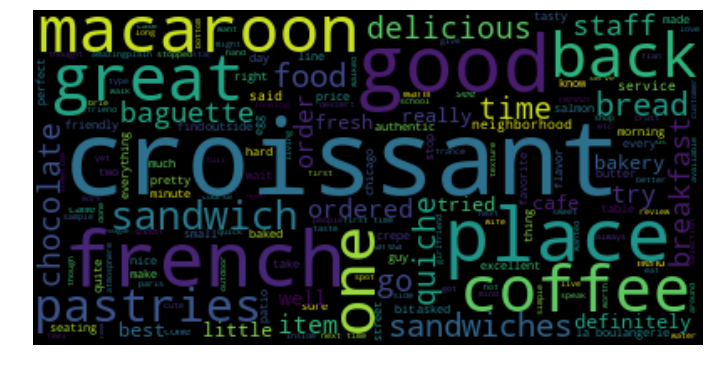

In [462]:
#Damen All Word Cloud
wordcloud = WordCloud().generate(damen_master_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('damen_wordcloud.png')

In [631]:
damen_review_concise = damen_review_df[['Date', 'Text', 'Stars', 'Useful', 'status', 'user_friends', 'user_reviews']]
damen_review_concise.head()

,Date,Text,Stars,Useful,status,user_friends,user_reviews
user_name,,,,,,,
Sonja M.,1/3/2019,I just stopped by this cafe for the first time...,5,0,not elite,63,22
Courtney J.,12/31/2018,I adore this neighborhood bakery. It is a few ...,5,0,elite,263,61
Sabrina G.,12/23/2018,I've been dreaming of quiche and croissants as...,5,0,elite,195,52
Alfie B.,10/10/2018,We came to La Boulangerie after recommendation...,5,0,elite,17,107
Anna L.,10/9/2018,This is a great breakfast spot. Even better if...,5,1,elite,28,176


In [632]:
damen_nlp_concise = damen_nlp_df[['id', 'Filtered']]
damen_nlp_concise.head()

,id,Filtered
0,Sonja M.,"[stopped, cafe, first, time, say, best, cafe, ..."
1,Courtney J.,"[adore, neighborhood, bakery, blocks, live, fi..."
2,Sabrina G.,"[dreaming, quiche, croissants, good, ones, par..."
3,Alfie B.,"[came, la, boulangerie, recommendation, cousin..."
4,Anna L.,"[great, breakfast, spot, even, better, looking..."


In [633]:
damen_merged_df = pd.merge(damen_review_concise, damen_nlp_concise, left_on='user_name', right_on='id', how='outer')
damen_merged_df.head()

,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered
0,1/3/2019,I just stopped by this cafe for the first time...,5,0,not elite,63,22,Sonja M.,"[stopped, cafe, first, time, say, best, cafe, ..."
1,12/31/2018,I adore this neighborhood bakery. It is a few ...,5,0,elite,263,61,Courtney J.,"[adore, neighborhood, bakery, blocks, live, fi..."
2,12/23/2018,I've been dreaming of quiche and croissants as...,5,0,elite,195,52,Sabrina G.,"[dreaming, quiche, croissants, good, ones, par..."
3,10/10/2018,We came to La Boulangerie after recommendation...,5,0,elite,17,107,Alfie B.,"[came, la, boulangerie, recommendation, cousin..."
4,10/9/2018,This is a great breakfast spot. Even better if...,5,1,elite,28,176,Anna L.,"[great, breakfast, spot, even, better, looking..."


In [634]:
damen_merged_df = damen_merged_df.drop(index=9)
damen_merged_df = damen_merged_df.drop(index=8).reset_index(drop=True)
damen_merged_df.head()

,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered
0,1/3/2019,I just stopped by this cafe for the first time...,5,0,not elite,63,22,Sonja M.,"[stopped, cafe, first, time, say, best, cafe, ..."
1,12/31/2018,I adore this neighborhood bakery. It is a few ...,5,0,elite,263,61,Courtney J.,"[adore, neighborhood, bakery, blocks, live, fi..."
2,12/23/2018,I've been dreaming of quiche and croissants as...,5,0,elite,195,52,Sabrina G.,"[dreaming, quiche, croissants, good, ones, par..."
3,10/10/2018,We came to La Boulangerie after recommendation...,5,0,elite,17,107,Alfie B.,"[came, la, boulangerie, recommendation, cousin..."
4,10/9/2018,This is a great breakfast spot. Even better if...,5,1,elite,28,176,Anna L.,"[great, breakfast, spot, even, better, looking..."


In [636]:
belmont_review_concise = belmont_review_df[['user_name', 'Date', 'Text', 'Stars', 'Useful', 'status', 'user_friends', 'user_reviews']]
belmont_nlp_concise = belmont_nlp_df[['id', 'Filtered']]
belmont_merged_df = pd.merge(belmont_review_concise, belmont_nlp_concise, left_on='user_name', right_on='id', how='outer')
belmont_merged_df.head()


,user_name,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered
0,Elise M.,12/27/2018,2018 Updated Review:This place closed for seve...,4,0,not elite,0,36,Elise M.,"[2018, updated, review, :, place, closed, seve..."
1,John D.,7/1/2018,Such a beautiful pleasant atmosphere. Highly r...,5,0,not elite,1,134,John D.,"[beautiful, pleasant, atmosphere, highly, reco..."
2,Hunny B.,5/3/2018,I am reluctant to write this review because I ...,4,0,not elite,5,31,Hunny B.,"[reluctant, write, review, understand, restaur..."
3,Tee L.,3/21/2018,Cute lil set up with courteous staff. First ti...,4,0,not elite,7,139,Tee L.,"[cute, lil, set, courteous, staff, first, time..."
4,Rose O.,3/9/2018,Their caprese sandwich is just OK but i really...,4,0,not elite,408,98,Rose O.,"[caprese, sandwich, ok, really, like, diplomat..."


In [637]:
belmont_merged_df = belmont_merged_df.drop(index=18)
belmont_merged_df = belmont_merged_df.drop(index=19).reset_index(drop=True)
belmont_merged_df.head()

,user_name,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered
0,Elise M.,12/27/2018,2018 Updated Review:This place closed for seve...,4,0,not elite,0,36,Elise M.,"[2018, updated, review, :, place, closed, seve..."
1,John D.,7/1/2018,Such a beautiful pleasant atmosphere. Highly r...,5,0,not elite,1,134,John D.,"[beautiful, pleasant, atmosphere, highly, reco..."
2,Hunny B.,5/3/2018,I am reluctant to write this review because I ...,4,0,not elite,5,31,Hunny B.,"[reluctant, write, review, understand, restaur..."
3,Tee L.,3/21/2018,Cute lil set up with courteous staff. First ti...,4,0,not elite,7,139,Tee L.,"[cute, lil, set, courteous, staff, first, time..."
4,Rose O.,3/9/2018,Their caprese sandwich is just OK but i really...,4,0,not elite,408,98,Rose O.,"[caprese, sandwich, ok, really, like, diplomat..."


In [639]:
logan_review_concise = logan_review_df[['user_name', 'Date', 'Text', 'Stars', 'Useful', 'status', 'user_friends', 'user_reviews']]
logan_nlp_concise = logan_nlp_df[['id', 'Filtered']]
logan_merged_df = pd.merge(logan_review_concise, logan_nlp_concise, left_on='user_name', right_on='id', how='outer')
logan_merged_df.head()


,user_name,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered
0,Erin H.,12/29/2018,This place has the BEST croissant I've had in ...,5,0,not elite,120,64,Erin H.,"[place, best, croissant, chicago, soft, crispy..."
1,Hope B.,11/13/2018,I found this French cafe accidentally when I o...,5,0,not elite,38,3,Hope B.,"[found, french, cafe, accidentally, originally..."
2,Katherine A.,11/13/2018,Yes. This is what you want. Comfortable feel...,5,0,elite,10,81,Katherine A.,"[yes, want, comfortable, feel, quality, espres..."
3,Anna G.,11/12/2018,Cozy spot for a quick bite or to settle in and...,5,1,elite,13,65,Anna G.,"[cozy, spot, quick, bite, settle, work, read, ..."
4,Kelly J.,10/19/2018,New York has nothing on French bakeries compar...,5,0,not elite,0,12,Kelly J.,"[new, york, nothing, french, bakeries, compare..."


In [640]:
damen_low_star_list = []
damen_high_star_list = []
for index, row in damen_merged_df.loc[damen_merged_df['Stars'] < 3, :].iterrows():
    damen_low_star_list = damen_low_star_list + row['Filtered']
for index, row in damen_merged_df.loc[damen_merged_df['Stars'] > 3, :].iterrows():
    damen_high_star_list = damen_high_star_list + row['Filtered']

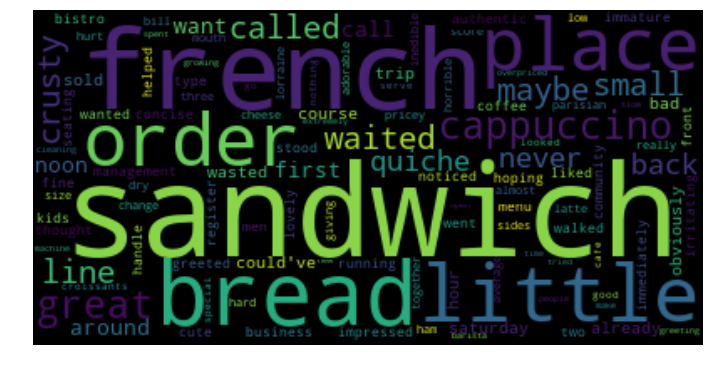

In [641]:
#Damen Low Star Word Cloud (1-2)
damen_low_star_string = ' '.join(damen_low_star_list)
wordcloud = WordCloud().generate(damen_low_star_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('damen_low_star_wordcloud.png')

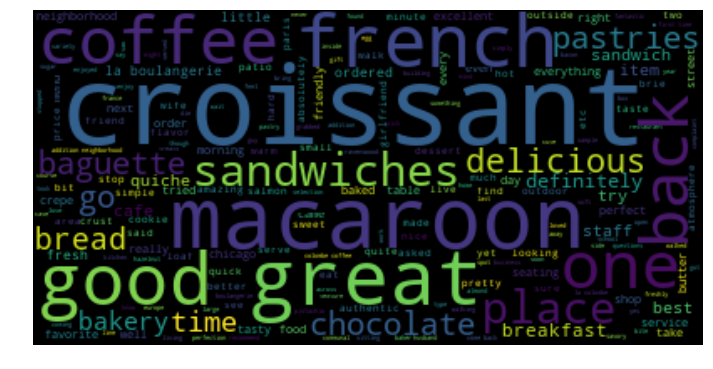

In [642]:
#Damen High Star Word Cloud (4-5)
damen_high_star_string = ' '.join(damen_high_star_list)
wordcloud = WordCloud().generate(damen_high_star_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('damen_high_star_wordcloud.png')

In [547]:
import seaborn as sns

In [552]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [643]:
for index, row in damen_merged_df.iterrows():
#     string = ' '.join(row['Filtered'])
    results = analyzer.polarity_scores(row['Text'])
    damen_merged_df.loc[index, 'sent_comp'] = results['compound'] 
    damen_merged_df.loc[index, 'sent_neg'] = results['neg']
    damen_merged_df.loc[index, 'sent_neu'] = results['neu']
    damen_merged_df.loc[index, 'sent_pos'] = results['pos']
    
damen_merged_df.head()

,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered,sent_comp,sent_neg,sent_neu,sent_pos
0,1/3/2019,I just stopped by this cafe for the first time...,5,0,not elite,63,22,Sonja M.,"[stopped, cafe, first, time, say, best, cafe, ...",0.7678,0.050,0.841,0.109
1,12/31/2018,I adore this neighborhood bakery. It is a few ...,5,0,elite,263,61,Courtney J.,"[adore, neighborhood, bakery, blocks, live, fi...",0.9580,0.032,0.796,0.172
2,12/23/2018,I've been dreaming of quiche and croissants as...,5,0,elite,195,52,Sabrina G.,"[dreaming, quiche, croissants, good, ones, par...",-0.0516,0.091,0.821,0.088
3,10/10/2018,We came to La Boulangerie after recommendation...,5,0,elite,17,107,Alfie B.,"[came, la, boulangerie, recommendation, cousin...",0.9472,0.000,0.851,0.149
4,10/9/2018,This is a great breakfast spot. Even better if...,5,1,elite,28,176,Anna L.,"[great, breakfast, spot, even, better, looking...",0.9501,0.000,0.804,0.196


In [644]:
for index, row in belmont_merged_df.iterrows():
#     string = ' '.join(row['Filtered'])
    results = analyzer.polarity_scores(row['Text'])
    belmont_merged_df.loc[index, 'sent_comp'] = results['compound'] 
    belmont_merged_df.loc[index, 'sent_neg'] = results['neg']
    belmont_merged_df.loc[index, 'sent_neu'] = results['neu']
    belmont_merged_df.loc[index, 'sent_pos'] = results['pos']
    
belmont_merged_df.head()

,user_name,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered,sent_comp,sent_neg,sent_neu,sent_pos
0,Elise M.,12/27/2018,2018 Updated Review:This place closed for seve...,4,0,not elite,0,36,Elise M.,"[2018, updated, review, :, place, closed, seve...",0.9961,0.000,0.749,0.251
1,John D.,7/1/2018,Such a beautiful pleasant atmosphere. Highly r...,5,0,not elite,1,134,John D.,"[beautiful, pleasant, atmosphere, highly, reco...",0.9115,0.000,0.575,0.425
2,Hunny B.,5/3/2018,I am reluctant to write this review because I ...,4,0,not elite,5,31,Hunny B.,"[reluctant, write, review, understand, restaur...",0.9933,0.065,0.701,0.234
3,Tee L.,3/21/2018,Cute lil set up with courteous staff. First ti...,4,0,not elite,7,139,Tee L.,"[cute, lil, set, courteous, staff, first, time...",0.9725,0.047,0.586,0.367
4,Rose O.,3/9/2018,Their caprese sandwich is just OK but i really...,4,0,not elite,408,98,Rose O.,"[caprese, sandwich, ok, really, like, diplomat...",0.9569,0.000,0.474,0.526


In [645]:
for index, row in logan_merged_df.iterrows():
#     string = ' '.join(row['Filtered'])
    results = analyzer.polarity_scores(row['Text'])
    logan_merged_df.loc[index, 'sent_comp'] = results['compound'] 
    logan_merged_df.loc[index, 'sent_neg'] = results['neg']
    logan_merged_df.loc[index, 'sent_neu'] = results['neu']
    logan_merged_df.loc[index, 'sent_pos'] = results['pos']
    
logan_merged_df.head()

,user_name,Date,Text,Stars,Useful,status,user_friends,user_reviews,id,Filtered,sent_comp,sent_neg,sent_neu,sent_pos
0,Erin H.,12/29/2018,This place has the BEST croissant I've had in ...,5,0,not elite,120,64,Erin H.,"[place, best, croissant, chicago, soft, crispy...",0.9764,0.000,0.671,0.329
1,Hope B.,11/13/2018,I found this French cafe accidentally when I o...,5,0,not elite,38,3,Hope B.,"[found, french, cafe, accidentally, originally...",0.9608,0.012,0.826,0.162
2,Katherine A.,11/13/2018,Yes. This is what you want. Comfortable feel...,5,0,elite,10,81,Katherine A.,"[yes, want, comfortable, feel, quality, espres...",0.9176,0.016,0.786,0.198
3,Anna G.,11/12/2018,Cozy spot for a quick bite or to settle in and...,5,1,elite,13,65,Anna G.,"[cozy, spot, quick, bite, settle, work, read, ...",0.8750,0.000,0.820,0.180
4,Kelly J.,10/19/2018,New York has nothing on French bakeries compar...,5,0,not elite,0,12,Kelly J.,"[new, york, nothing, french, bakeries, compare...",0.9515,0.000,0.605,0.395


In [548]:
# elite_damen = damen_merged_df.loc[damen_merged_df['status']=='elite', :]
# non_elite_damen = damen_merged_df.loc[damen_merged_df['status']=='not elite', :]

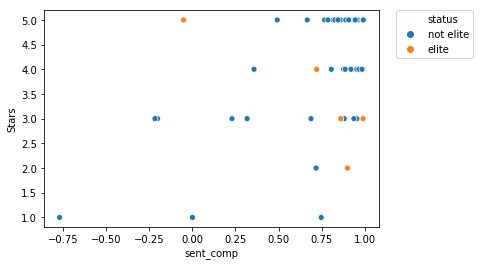

In [646]:
#Damen Sentiment V Stars
sns.scatterplot(x='sent_comp', \
                y='Stars', data=damen_merged_df, hue='status')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [697]:
damen_merged_df['Branch'] = 'Damen'
damen_merged_df['Branch_Num'] = 1
belmont_merged_df['Branch'] = 'Belmont'
belmont_merged_df['Branch_Num'] = 2
logan_merged_df['Branch'] = 'Logan'
logan_merged_df['Branch_Num'] = 3

In [698]:
merged_master_df = pd.concat([damen_merged_df, belmont_merged_df, logan_merged_df]).reset_index(drop=True)
len(merged_master_df)

/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


284

In [699]:
merged_master_df = merged_master_df[['Branch', 'Branch_Num', 'Date', 'Text', 'Filtered', 'Stars', 'Useful', 'id', 'sent_comp', 'sent_neg', 'sent_neu',\
                                     'sent_pos', 'status', 'user_friends', 'user_reviews']]

In [700]:
merged_master_df.head()

,Branch,Branch_Num,Date,Text,Filtered,Stars,Useful,id,sent_comp,sent_neg,sent_neu,sent_pos,status,user_friends,user_reviews
0,Damen,1,1/3/2019,I just stopped by this cafe for the first time...,"[stopped, cafe, first, time, say, best, cafe, ...",5,0,Sonja M.,0.7678,0.050,0.841,0.109,not elite,63,22
1,Damen,1,12/31/2018,I adore this neighborhood bakery. It is a few ...,"[adore, neighborhood, bakery, blocks, live, fi...",5,0,Courtney J.,0.9580,0.032,0.796,0.172,elite,263,61
2,Damen,1,12/23/2018,I've been dreaming of quiche and croissants as...,"[dreaming, quiche, croissants, good, ones, par...",5,0,Sabrina G.,-0.0516,0.091,0.821,0.088,elite,195,52
3,Damen,1,10/10/2018,We came to La Boulangerie after recommendation...,"[came, la, boulangerie, recommendation, cousin...",5,0,Alfie B.,0.9472,0.000,0.851,0.149,elite,17,107
4,Damen,1,10/9/2018,This is a great breakfast spot. Even better if...,"[great, breakfast, spot, even, better, looking...",5,1,Anna L.,0.9501,0.000,0.804,0.196,elite,28,176


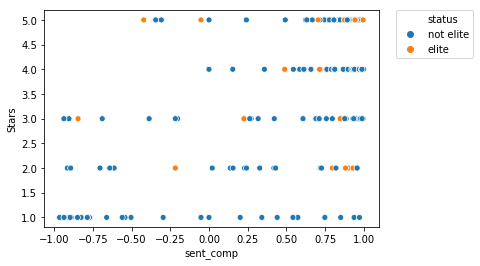

In [701]:
sns.scatterplot(x='sent_comp', \
                y='Stars', data=merged_master_df, hue='status')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [702]:
merged_master_df.to_csv('master_sentiment.csv')

In [703]:
for index, row in merged_master_df.iterrows():
    if row['status'] == 'elite':
        merged_master_df.loc[index, ['status']] = 1
    elif row['status'] == 'not elite':
        merged_master_df.loc[index, ['status']] = 0
merged_master_df.head()

,Branch,Branch_Num,Date,Text,Filtered,Stars,Useful,id,sent_comp,sent_neg,sent_neu,sent_pos,status,user_friends,user_reviews
0,Damen,1,1/3/2019,I just stopped by this cafe for the first time...,"[stopped, cafe, first, time, say, best, cafe, ...",5,0,Sonja M.,0.7678,0.050,0.841,0.109,0,63,22
1,Damen,1,12/31/2018,I adore this neighborhood bakery. It is a few ...,"[adore, neighborhood, bakery, blocks, live, fi...",5,0,Courtney J.,0.9580,0.032,0.796,0.172,1,263,61
2,Damen,1,12/23/2018,I've been dreaming of quiche and croissants as...,"[dreaming, quiche, croissants, good, ones, par...",5,0,Sabrina G.,-0.0516,0.091,0.821,0.088,1,195,52
3,Damen,1,10/10/2018,We came to La Boulangerie after recommendation...,"[came, la, boulangerie, recommendation, cousin...",5,0,Alfie B.,0.9472,0.000,0.851,0.149,1,17,107
4,Damen,1,10/9/2018,This is a great breakfast spot. Even better if...,"[great, breakfast, spot, even, better, looking...",5,1,Anna L.,0.9501,0.000,0.804,0.196,1,28,176


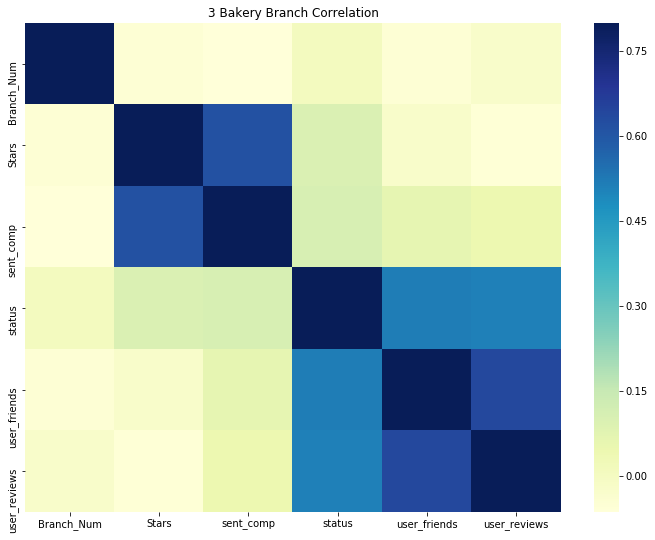

In [705]:
corrmat = merged_master_df[['Branch_Num', 'Stars', 'sent_comp', 'status', 'user_friends', 'user_reviews']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns_plot = sns.heatmap(corrmat, vmax=.8, cmap="YlGnBu").set_title('3 Bakery Branch Correlation')

In [691]:
merged_master_df.columns

Index(['Branch', 'Date', 'Text', 'Filtered', 'Stars', 'Useful', 'id',
       'sent_comp', 'sent_neg', 'sent_neu', 'sent_pos', 'status',
       'user_friends', 'user_reviews'],
      dtype='object')

In [707]:
master_array = []
for index, row in merged_master_df.iterrows():
    master_array = master_array + row['Filtered']
len(master_array)

14580

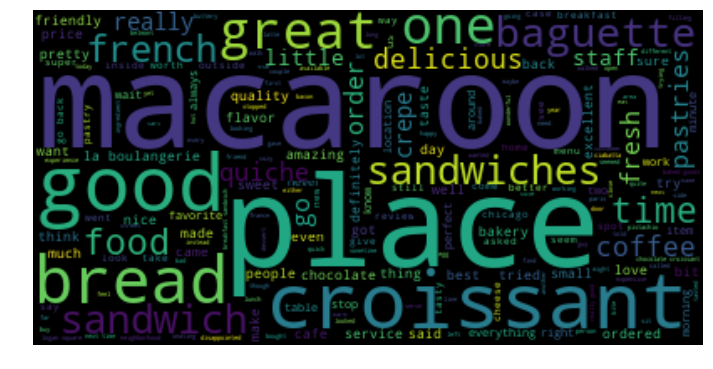

In [708]:
master_array_string = ' '.join(master_array)
wordcloud = WordCloud().generate(master_array_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('master_wordcloud.png')

In [710]:
master_low_star_list = []
master_high_star_list = []
for index, row in merged_master_df.loc[merged_master_df['Stars'] < 3, :].iterrows():
    master_low_star_list = master_low_star_list + row['Filtered']
for index, row in merged_master_df.loc[merged_master_df['Stars'] > 3, :].iterrows():
    master_high_star_list = master_high_star_list + row['Filtered']
print(len(master_low_star_list))
print(len(master_high_star_list))

3030
9067


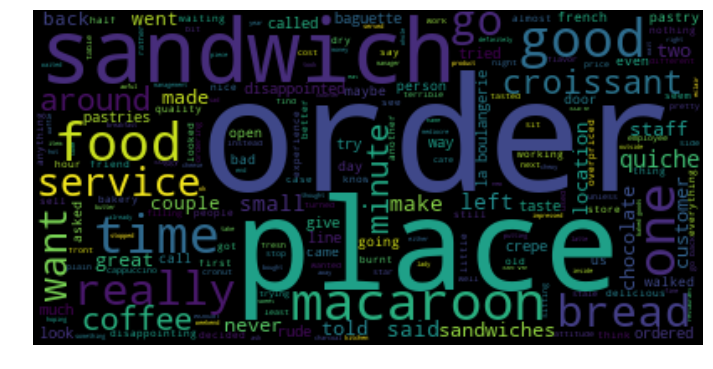

In [711]:
master_low_string = ' '.join(master_low_star_list)
wordcloud = WordCloud().generate(master_low_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('master_low_wordcloud.png')

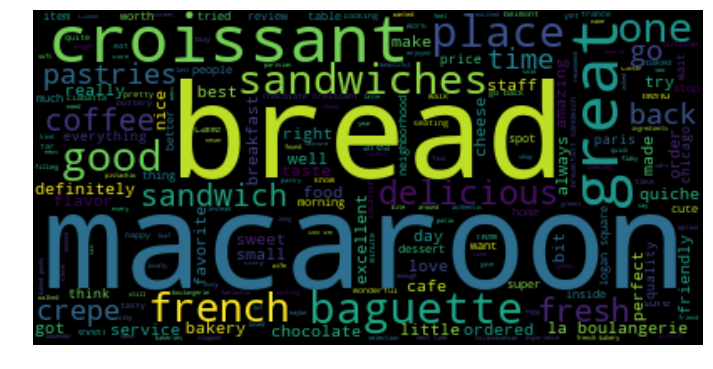

In [712]:
master_high_string = ' '.join(master_high_star_list)
wordcloud = WordCloud().generate(master_high_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('master_high_wordcloud.png')